In [2]:
import sys 
sys.path.append('/home/lumargot/trachoma/src/py')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # put -1 to not use any

In [3]:
# import sys; sys.path.insert(0, '..')
# import
from tqdm import tqdm
import math
import os
import pandas as pd
import numpy as np 

import torch
from torch import Tensor, nn
from torchvision import models
from torchvision import ops

from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk
import nrrd
import pytorch_lightning as pl
from torchvision import transforms
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from monai.data.utils import pad_list_data_collate

import lightning as L
from lightning.pytorch.core import LightningModule
import monai
from torchvision.transforms import functional as F


from matplotlib.patches import Rectangle


from torchvision.ops import nms
from scipy.optimize import linear_sum_assignment

from nets.segmentation import FasterRCNN
from loaders.tt_dataset import TTDatasetBX,TTDataModuleBX, BBXImageTrainTransform, BBXImageEvalTransform, BBXImageTestTransform

/home/lumargot/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [4]:
def remove_labels(df, class_column, label_column, drop_labels=None, concat_labels=None):

  if drop_labels is not None:
      df = df[ ~ df[label_column].isin(drop_labels)]

  if concat_labels is not None:
      replacement_val = df.loc[ df['label'] == concat_labels[0]]['class'].unique()
      df.loc[ df['label'].isin(concat_labels), "class" ] = replacement_val[0]

  unique_classes = sorted(df[class_column].unique())
  class_mapping = {value: idx for idx, value in enumerate(unique_classes)}

  df[class_column] = df[class_column].map(class_mapping)    
  print(f"Kept Classes : {df[label_column].unique()}, {class_mapping}")

  return df

def compute_bbx_iou(gt_box, pred_box):
    """
    Compute IoU for two bounding boxes.
    Each box should be [x1, y1, x2, y2]
    """
    x1 = max(gt_box[0], pred_box[0])
    y1 = max(gt_box[1], pred_box[1])
  
    x2 = min(gt_box[2], pred_box[2])
    y2 = min(gt_box[3], pred_box[3])

    interArea = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    gt_boxArea = (gt_box[2] - gt_box[0] + 1) * (gt_box[3] - gt_box[1] + 1)
    pred_boxArea = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)
    iou = interArea / float(gt_boxArea + pred_boxArea - interArea)
    return iou


def match_boxes(gt_boxes, pred_boxes):
    """Match predicted boxes to ground truth boxes using the Hungarian algorithm."""
    
    if len(gt_boxes) == 0 or len(pred_boxes) == 0:
        return [], []

    # Compute cost matrix (distance between centers)
    cost_matrix = np.zeros((len(gt_boxes), len(pred_boxes)))

    for i, (x1_gt, y1_gt, x2_gt, y2_gt) in enumerate(gt_boxes):
        center_gt = np.array([(x1_gt + x2_gt) / 2, (y1_gt + y2_gt) / 2])
        
        for j, (x1_pred, y1_pred, x2_pred, y2_pred) in enumerate(pred_boxes):
            center_pred = np.array([(x1_pred + x2_pred) / 2, (y1_pred + y2_pred) / 2])
            cost_matrix[i, j] = np.linalg.norm(center_gt - center_pred)  # Euclidean distance

    # Solve assignment problem (minimize distance)
    gt_indices, pred_indices = linear_sum_assignment(cost_matrix)

    return gt_indices, pred_indices

def evaluate_with_fp_fn(gt_boxes, pred_boxes):
    gt_indices, pred_indices = match_boxes(gt_boxes, pred_boxes)

    distances = []
    ious = []
    num_pred =0
    for gt_idx, pred_idx in zip(gt_indices, pred_indices):
        num_pred+=1
        x1_gt, y1_gt, x2_gt, y2_gt = gt_boxes[gt_idx]
        x1_pred, y1_pred, x2_pred, y2_pred = pred_boxes[pred_idx]

        iou = compute_bbx_iou(gt_boxes[gt_idx], pred_boxes[pred_idx])
        ious.append(iou)
        # Compute center distance
        center_gt = np.array([(x1_gt + x2_gt) / 2, (y1_gt + y2_gt) / 2])
        center_pred = np.array([(x1_pred + x2_pred) / 2, (y1_pred + y2_pred) / 2])
        distances.append(np.linalg.norm(center_gt - center_pred))
    
    # Count false positives (unmatched predictions)
    num_false_positives = len(pred_boxes) - len(pred_indices)

    # Count false negatives (unmatched GT boxes)
    num_false_negatives = len(gt_boxes) - len(gt_indices)
    return num_pred, num_false_positives, num_false_negatives, ious, distances

In [90]:
mount_point = "/CMF/data/lumargot/trachoma/B images one eye/"

df_test = pd.read_csv('/CMF/data/lumargot/trachoma/patches/csv/new/Pret_excluded_clean_fold0_test.csv')
df_val = pd.read_csv('/CMF/data/lumargot/trachoma/patches/csv/new/Pret_excluded_clean_fold0_train_test.csv')    
df_train = pd.read_csv('/CMF/data/lumargot/trachoma/patches/csv/new/Pret_excluded_clean_fold0_train_train.csv')


# df_test = df_test.loc[~df_test['label'].isin(['Healthy', 'Reject'])].reset_index()
# df_val = df_val.loc[~df_val['label'].isin(['Healthy', 'Reject'])].reset_index()
# df_train = df_train.loc[~df_train['label'].isin(['Healthy', 'Reject'])].reset_index()
concat_labels=['overcorrection', 'Short Incision', 'Entropion', 'ECA', 'Gap']
drop_labels = ['Reject'] # remove them for evaluation otherwise fake evaluation metrics
img_column= "filename" 
class_column = 'class'
label_column = 'label'
map = {0:'Healthy', 1:'Bad', 2:'Reject'}

In [91]:

df_test = remove_labels(df_test, class_column, label_column, drop_labels, concat_labels)
df_train = remove_labels(df_train, class_column, label_column, drop_labels, concat_labels)
df_val = remove_labels(df_val, class_column, label_column, drop_labels, concat_labels)

df_train['class'].value_counts()

Kept Classes : ['Healthy' 'Entropion' 'Gap' 'overcorrection' 'Short Incision' 'ECA'], {0: 0, 4: 1}
Kept Classes : ['Healthy' 'ECA' 'overcorrection' 'Entropion' 'Gap' 'Short Incision'], {0: 0, 4: 1}
Kept Classes : ['Gap' 'Healthy' 'Entropion' 'Short Incision' 'ECA' 'overcorrection'], {0: 0, 4: 1}



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    10185
1     6590
Name: class, dtype: int64

In [92]:
ttdata = TTDataModuleBX(df_train, df_val, df_test, batch_size=1, num_workers=2, 
                        img_column='filename', mount_point=mount_point, 
                        train_transform=BBXImageTrainTransform(), 
                        valid_transform=BBXImageEvalTransform(), 
                        test_transform=BBXImageTestTransform())

In [93]:
ttdata.setup()
dataload = ttdata.test_dataloader()
ds = ttdata.test_ds

img, box, classes = ds[0]

# Prediction

In [94]:
# ckpt = '/CMF/data/lumargot/trachoma/output/object_detection/fold0/epoch=2-val_loss=0.65.ckpt'
# ckpt  = '/CMF/data/lumargot/trachoma/output/object_detection/orign/fold0/last.ckpt'
ckpt='/CMF/data/lumargot/trachoma/output/object_detection/OallF_padsize/fold0/epoch=5-val_loss=1.89.ckpt'
ckpt = '/CMF/data/lumargot/trachoma/output/object_detection/anchors/fold0/epoch=6-val_loss=1.96.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/object_detection/orign/fold0/epoch=4-val_loss=2.06.ckpt'
model = FasterRCNN.load_from_checkpoint(ckpt)

In [95]:
model.eval()

num_preds = 0
num_fps = 0
num_fns = 0
l_ious = []
l_distances = []
for idx, batch in enumerate(tqdm(dataload)):
  
  # imgs, labels, boxes = batch
  
  targets = batch
  imgs = targets.pop('img', None)
  outs = model(imgs, mode='test')
  out_img = outs[0]
  # break


  ## also nms on ground truth, if there are too many labels; especially truth for MTSS dataset
  # in Pret, some images have a many labels. That's why with or without NMS doesn't change that much
  # the metrics
  
  pred_indices = nms(out_img['boxes'], out_img['scores'], iou_threshold=.4) ## iou as args
  gt_indices = nms(targets['boxes'][0], torch.ones_like(targets['boxes'][0,:,0]), iou_threshold=.5) ## iou as args

  gt_boxes = targets['boxes'][0][gt_indices].cpu().detach().numpy()
  pred_boxes = out_img['boxes'][pred_indices].cpu().detach().numpy()


  n_p, n_fp, n_fn, i, d = evaluate_with_fp_fn(gt_boxes, pred_boxes)
  num_preds += n_p
  num_fps += n_fp
  num_fns += n_fn
  l_ious.append(torch.tensor(i).reshape(-1))
  l_distances.append(torch.tensor(d))

ious = torch.cat(l_ious, dim=0)
dist = torch.cat(l_distances, dim=0)

print(f"Number of matched prediction: {num_preds}")
print(f"Fale Positive: {num_fps}, False Negatives:{num_fns}")
# false positive: unmatched prediction - false negative: unmatch boxes
print(f'mean IoU: {ious.mean()} with mean distance: {dist.mean()}')


  0%|          | 0/425 [00:00<?, ?it/s]

100%|██████████| 425/425 [03:36<00:00,  1.97it/s]

Number of matched prediction: 1757
Fale Positive: 7, False Negatives:3213
mean IoU: 0.5857726067459034 with mean distance: 42.39282851328697


## Inputs

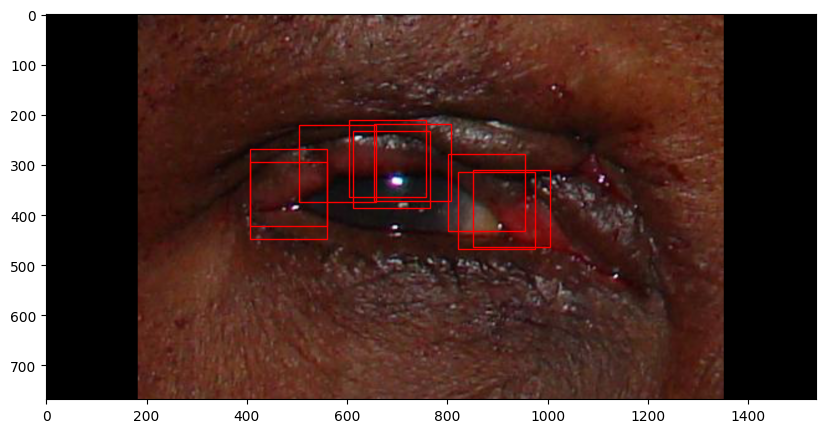

In [96]:
IDX=0
plt.figure(figsize=(10,5))
img = imgs[IDX].permute(1,2,0)
ax = plt.gca()
ax.imshow(img)

for box in targets['boxes'][0]:
  x1, y1, x2, y2 = box.cpu().detach().numpy()
  width, height = x2 - x1, y2 - y1
  rect = Rectangle((x1, y1), width, height, fill=False, color='red')
  ax.add_patch(rect)


## Prediction

5


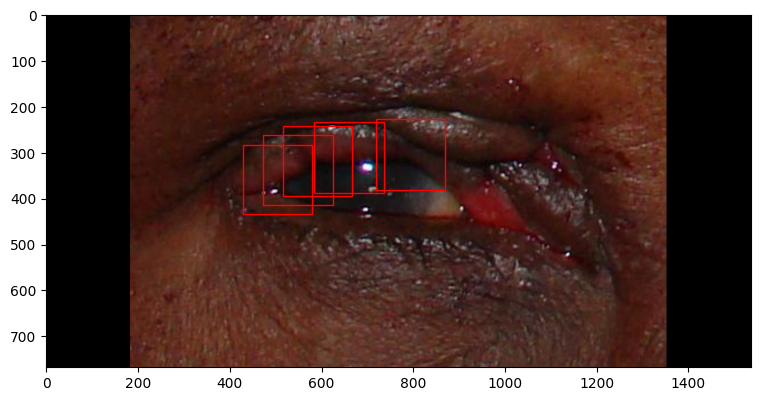

In [89]:
plt.figure(figsize=(20,10))
for i in range(1):
  plt.subplot(1,2,i+1)
  plt.imshow(imgs[i].permute(1,2,0))

  ax = plt.gca()
  out_img = outs[i]
  indices = nms(out_img['boxes'], out_img['scores'], iou_threshold=.5)
  print(len(indices))
  for j in indices:
    
    box = out_img['boxes'][j]
    label = out_img['labels'][j].cpu().detach().numpy()
    score = out_img['scores'][j].cpu().detach().numpy()

    x1, y1, x2, y2 = box.cpu().detach().numpy()
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    ax.add_patch(rect)

#### Evaluation

1. Use Hungarian Matching to assign predicted boxes to the closest GT boxes.
2. Compute Evaluation Metrics:
    - Center Distance Error
3. IoU

# Prediction on MTSS

In [68]:
mtss_train= '/CMF/data/lumargot/trachoma/PoPP_Data/annotations_train_train.csv'
mtss_valid= '/CMF/data/lumargot/trachoma/PoPP_Data/annotations_train_test.csv'
mtss_test= '/CMF/data/lumargot/trachoma/PoPP_Data/annotations_test.csv'
mtss_mp= '/CMF/data/lumargot/trachoma/PoPP_Data/mtss/'

df_mt_train = pd.read_csv(mtss_train) 
df_mt_val = pd.read_csv(mtss_valid)
df_mt_test = pd.read_csv(mtss_test)

df_mt_test = remove_labels(df_mt_test, class_column, label_column, drop_labels, concat_labels)
df_mt_train = remove_labels(df_mt_train, class_column, label_column, drop_labels, concat_labels)
df_mt_val = remove_labels(df_mt_val, class_column, label_column, drop_labels, concat_labels)

Kept Classes : ['Healthy' 'ECA' 'overcorrection' 'Gap' 'Entropion' 'Short Incision'], {0: 0, 4: 1}
Kept Classes : ['Healthy' 'ECA' 'overcorrection' 'Gap' 'Entropion' 'Short Incision'], {0: 0, 4: 1}
Kept Classes : ['Healthy' 'ECA' 'overcorrection' 'Entropion' 'Short Incision' 'Gap'], {0: 0, 4: 1}


In [69]:
import albumentations as A
class BBXImageTestTransform():
    def __init__(self):

        self.transform = A.Compose(
            [
                A.LongestMaxSize(max_size_hw=(768, None)),
                A.CenterCrop(height=768, width=1536, pad_if_needed=True),
            ], 
            bbox_params=A.BboxParams(format='pascal_voc', min_area=16, min_visibility=0.1, label_fields=['category_ids'])
        )

    def __call__(self, image, bboxes, category_ids):
        return self.transform(image=image, bboxes=bboxes, category_ids=category_ids)

In [70]:
mt_ttdata = TTDataModuleBX(df_mt_train, df_mt_val, df_mt_test, batch_size=1, num_workers=2, 
                        img_column='filename', mount_point=mtss_mp,
                        train_transform=BBXImageTestTransform(), 
                        valid_transform=BBXImageTestTransform(), 
                        test_transform=BBXImageTestTransform())

In [71]:
mt_ttdata.setup()
mt_dataload = mt_ttdata.test_dataloader()
mt_ds = mt_ttdata.test_ds

In [72]:
mt_ds[0]['img'].shape

torch.Size([3, 768, 1536])

In [73]:
for idx, batch in enumerate(tqdm(mt_dataload)):
    
  targets = batch
  imgs = targets.pop('img', None)

  outs = model(imgs, mode='test')
  out_img=outs[0]

  pred_indices = nms(out_img['boxes'], out_img['scores'], iou_threshold=.4) ## iou as args
  gt_indices = nms(targets['boxes'][0], torch.ones_like(targets['boxes'][0,:,0]), iou_threshold=.5) ## iou as args

  gt_boxes = targets['boxes'][0][gt_indices].cpu().detach().numpy()
  pred_boxes = out_img['boxes'][pred_indices].cpu().detach().numpy()

  n_p, n_fp, n_fn, i, d = evaluate_with_fp_fn(gt_boxes, pred_boxes)
  num_preds += n_p
  num_fps += n_fp
  num_fns += n_fn
  l_ious.append(torch.tensor(i).reshape(-1))
  l_distances.append(torch.tensor(d))

ious = torch.cat(l_ious, dim=0)
dist = torch.cat(l_distances, dim=0)

print(f"Number of matched prediction: {num_preds}")
print(f"FP: {num_fps}, FN:{num_fns}")
print(f'mean IoU: {ious.mean()} with mean distance: {dist.mean()}')


100%|██████████| 355/355 [01:06<00:00,  5.31it/s]

Number of matched prediction: 3217
FP: 182, FN:2920
mean IoU: 0.5952991688633722 with mean distance: 46.80102555202278


In [74]:
for idx, batch in enumerate(tqdm(mt_dataload)):
    
  targets = batch
  imgs = targets.pop('img', None)

  outs = model(imgs, mode='test')
  out_img=outs[0]

  pred_indices = nms(out_img['boxes'], out_img['scores'], iou_threshold=.4) ## iou as args
  gt_indices = nms(targets['boxes'][0], torch.ones_like(targets['boxes'][0,:,0]), iou_threshold=.5) ## iou as args

  gt_boxes = targets['boxes'][0][gt_indices].cpu().detach().numpy()
  pred_boxes = out_img['boxes'][pred_indices].cpu().detach().numpy()

  if idx ==3:
    break


  1%|          | 3/355 [00:01<02:47,  2.10it/s]


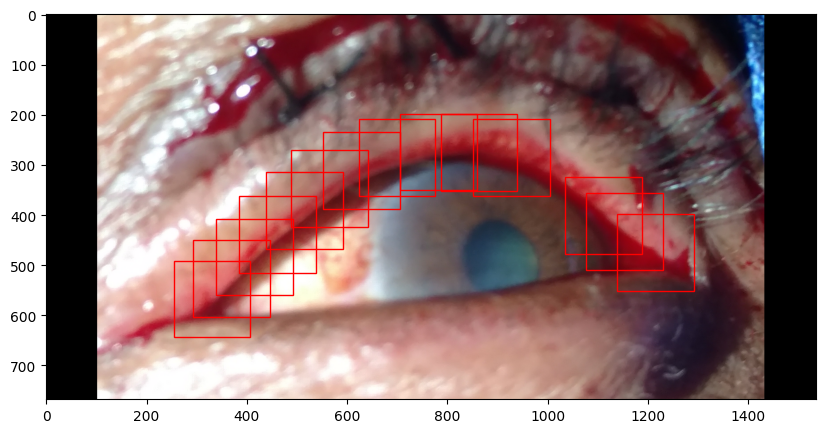

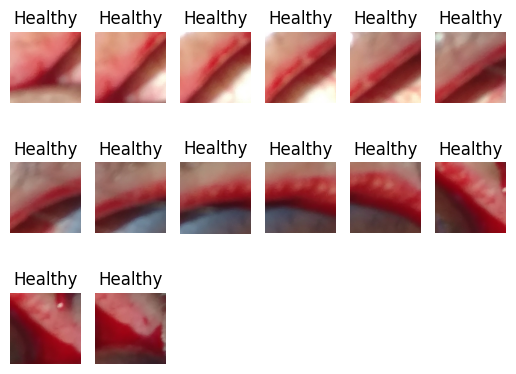

In [75]:
plt.figure(figsize=(10,5))
img = imgs[0].permute(1,2,0)
num_cols = 6
target = targets #[IDX]

ax = plt.gca()
ax.imshow(img)

indices = nms(target['boxes'][0], torch.ones_like(target['boxes'][0,:,0]), iou_threshold=.5) ## iou as args
num_rows = int(len(indices)/num_cols) +1

for j in indices:
  box = target['boxes'][0][j]
  label = target['labels'][0][j]

  x1, y1, x2, y2 = box.cpu().detach().numpy()
  width, height = x2 - x1, y2 - y1
  rect = Rectangle((x1, y1), width, height, fill=False, color='red')
  ax.add_patch(rect)
plt.show()
plot_idx = 1
for j in indices:
  box = target['boxes'][0][j]
  label = target['labels'][0][j]

  plt.subplot(num_rows,num_cols,plot_idx)
  x1, y1, x2, y2 = box.cpu().detach().numpy()
  img_cropped = img[int(y1):int(y2), int(x1):int(x2), :]

  plt.imshow(img_cropped)
  plt.axis('off')
  plt.title(map[label.item()])
  plot_idx +=1

6


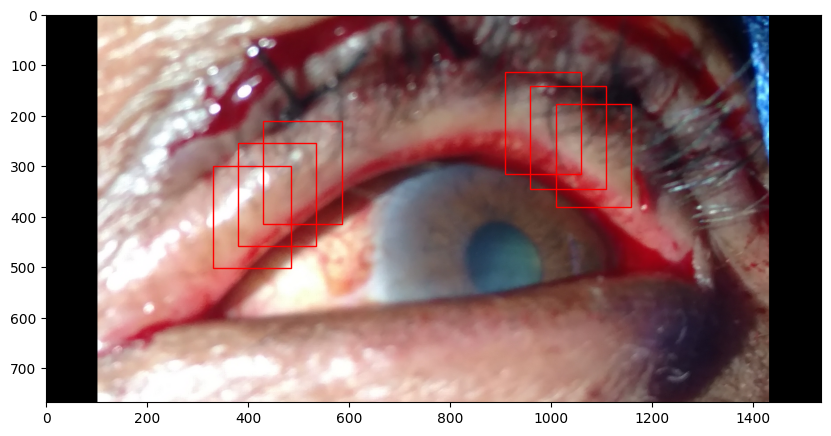

In [81]:
plt.figure(figsize=(10,10))

for i in range(1):
  plt.imshow(imgs[i].permute(1,2,0))

  ax = plt.gca()
  out_img = outs[i]
  indices = nms(out_img['boxes'], out_img['scores'], iou_threshold=.4)
  print(len(indices))

  for j in indices:
        
    box = out_img['boxes'][j]
    label = out_img['labels'][j].cpu().detach().numpy()
    score = out_img['scores'][j].cpu().detach().numpy()

    x1, y1, x2, y2 = box.cpu().detach().numpy()
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1-125), width, height+50, fill=False, color='red')
    ax.add_patch(rect)

##### area + classification by faster r cnn

In [44]:
tr_resize = transforms.Resize((512,512))

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


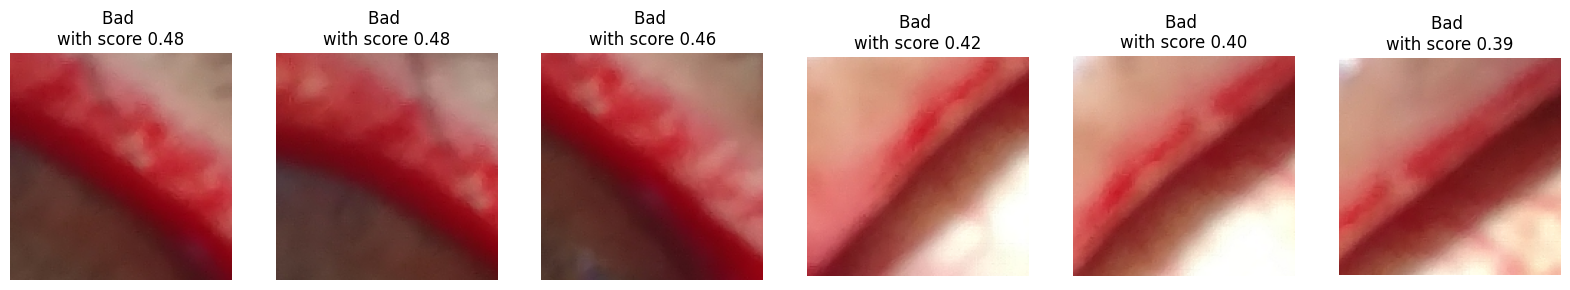

In [82]:
map = {0:'Healthy', 1:'Bad', 2:'Reject'}
out_img = outs[0]
num_cols = 6
num_rows = int(len(out_img['labels'])/num_cols) +1
plt.figure(figsize=(20,10))
patches = []

i_plot = 1
for j in indices:
  box = out_img['boxes'][j]
  label = out_img['labels'][j]
  score =out_img['scores'][j].cpu().detach().numpy()
  plt.subplot(num_rows,num_cols,i_plot)
  x1, y1, x2, y2 = box.cpu().detach().numpy()

  img_cropped = img[int(y1) :int(y2), int(x1):int(x2), :]
  plt.imshow(img_cropped)
  plt.axis('off')
  plt.title(f"{map[label.item()]} \nwith score {score:.2f}")
  i_plot+=1

  img_cropped = tr_resize(img_cropped.permute(2,0,1))
  patches.append(img_cropped.unsqueeze(0))


patches = torch.cat(patches)

##### Classification model on area detected by faster r-cnn

In [50]:
from nets.classification import EfficientNetV2SYOLTPatchv2,EfficientnetV2s

In [51]:
ckpt = '/CMF/data/lumargot/trachoma/output/patches/subset_models/rejection_class/HealthyXBadXReject/fold4/epoch=27-val_loss=0.36.ckpt'
mone = EfficientnetV2s.load_from_checkpoint(ckpt).cuda()
mone.eval()

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.


EfficientnetV2s(
  (loss): CrossEntropyLoss()
  (accuracy): MulticlassAccuracy()
  (model): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), pa

In [84]:
out = mone(patches.cuda())

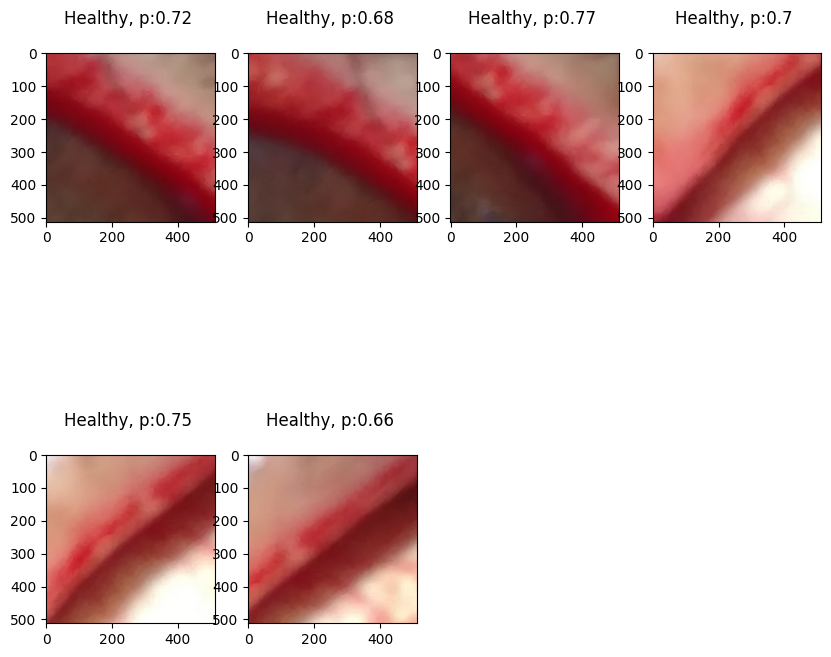

In [85]:
plt.figure(figsize=(10,20))
val, labels = torch.max(out, dim=1)
for i in range(patches.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(patches[i].permute(1,2,0))

  prob = str(np.around(val[i].detach().cpu().numpy(), 2))

  plt.title(f"{map[labels[i].detach().cpu().item()]}, p:{prob} \n")
